In [5]:
import numpy as np
import random
import math
from scipy.stats import multivariate_normal, norm
import derivatives as dev
from tqdm import tqdm
import matplotlib.pyplot as plt
import lambda_sampler as ls
import tau_sampler as ts
from scipy.stats import halfcauchy

In [6]:
extracted_coefficients_directory = '../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)#[0:B_zeta.shape[0]]
n = B_zeta.shape[0]
p = B_zeta.shape[1]

beta = np.repeat(0,10)
Lambda_old = np.repeat(1,p)
BoB = B_zeta**2
log_tau_old = math.log(0.5)
dS2_old, ddS2_old, S2_old, S_old = dev.generate_dS2_ddS2_S2_S(Lambda_old, BoB)

In [7]:
# initialize Lambda
betaBt = beta.dot(B_zeta.T)

In [17]:
num_iterations = 100000
lambdaacc = np.zeros((len(Lambda_old),num_iterations))
all_betas = []
all_lambdas = []
tauacc = []
all_taus = []
for j in tqdm(range(0, num_iterations)):
    
    beta = ts.sample_beta(p, B_zeta, Lambda_old, S_old, z)
    all_betas.append(beta)
    
    betaBt = beta.dot(B_zeta.T)
    
    # update tau
    log_tau_new, decision_criterion_tau = ts.sample_tau(log_tau_old, Lambda_old, p)
    # decision to accept/reject tau
    if np.log(np.random.uniform(0,1,1)) <= decision_criterion_tau:
        log_tau_old = log_tau_new
        tauacc.append(1)
        all_taus.append(log_tau_new)
    else:
        tauacc.append(0)
        all_taus.append(log_tau_old)
    
    # update lambda
    for m in range(0, len(Lambda_old)):
        log_sq_lambda_new, decision_criterion_lambda, dS2_new, ddS2_new, S2_new, S_new, ddlunew, Lambda_new = ls.sample_lambda(m, 
                                                                                               log_tau_old, 
                                                                                               Lambda_old, p, beta, 
                                                                                               B_zeta, dS2_old, ddS2_old, 
                                                                                              S2_old, S_old, z, BoB, betaBt)

        if np.log(np.random.uniform(0,1,1)) <= decision_criterion_lambda:
           # if m < p - 1:
            #    Lambda_old = np.append(np.append(Lambda_old[0:m], math.exp(0.5*log_sq_lambda_new)), Lambda_old[m + 1:])
            #elif m == p - 1:
            #    Lambda_old = np.append(Lambda_old[0:m],  math.exp(0.5*log_sq_lambda_new))
            Lambda_old = Lambda_new.copy()
            lambdaacc[m,j] += 1
            all_lambdas.append(Lambda_old)
            dS2_old, ddS2_old, S2_old, S_old = dS2_new, ddS2_new, S2_new, S_new
        
        else:
            lambdaacc[m,j] += 0
            all_lambdas.append(Lambda_old)  

  7%|▋         | 7175/100000 [1:00:39<13:04:39,  1.97it/s]


KeyboardInterrupt: 

In [18]:
print('Acceptance rate for lambda_js: ' + str(np.sum(lambdaacc/num_iterations, axis = 1))
     + '\nAcceptance rate for tau: ' + str(np.mean(tauacc)))


Acceptance rate for lambda_js: [0.04315 0.      0.04441 0.      0.      0.      0.      0.      0.
 0.     ]
Acceptance rate for tau: 0.9646042363433668


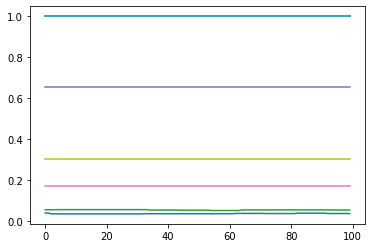

In [19]:
plt.plot(all_lambdas[-100:])

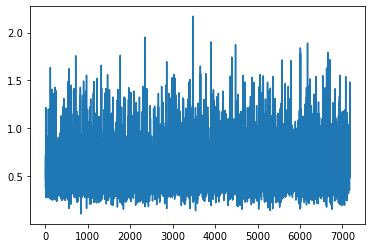

In [20]:
plt.plot(np.exp(all_taus))